In [1]:
import pandas as pd
import numpy as np
import subprocess
import gffutils
import screed
from screed import ScreedDB
from Bio.Seq import Seq
import re
import sys
sys.path.append('/scratch/jho5ze/bionets/covid/scripts')
import entropy_utils as eu
import networkx as nx

In [2]:
metadata = pd.read_csv("../data/metadata_2021_04_08.tsv", sep="\t", parse_dates = ["Collection date", "Submission date"])

metadata = metadata[["Accession ID", \
                   "Collection date", \
                   "Submission date", \
                   "Location", \
                   "Additional location information", \
                   "Sequence length", \
                   "Host", \
                   "AA Substitutions", \
                   "Is reference?"]]
def get_nth_slash(row, n):
    try:
        return row.split("/")[n].strip()
    except:
        return np.nan
    
for i in range(4):
    metadata[f"Location_{i}"] = metadata["Location"].apply(lambda row: get_nth_slash(row, i))
metadata = metadata.rename(columns={"Location_1":"country", "Location_2":"state"})

/apps/software/standard/compiler/gcc/9.2.0/jupyter_conda/2019.10-py3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (13,16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [18]:
msadb = ScreedDB("../data/msa_0408/usa_msa_0408.fasta")

In [7]:
orig_orfs = []
for line in open("../data/GCF_009858895.2_ASM985889v3_genomic.gff").readlines():
    line = line.strip().split()
    if len(line) < 5:
        continue
    if line[2] == "CDS":
        orig_orfs.append((int(line[3]), int(line[4])))

orfs = sorted(orig_orfs, key = lambda tup: tup[1], reverse=True)[:-1] #Last one is just a truncated version of the second to last one

In [19]:
orfs

[(29558, 29674),
 (28274, 29533),
 (27894, 28259),
 (27756, 27887),
 (27394, 27759),
 (27202, 27387),
 (26523, 27191),
 (26245, 26472),
 (25393, 26220),
 (21563, 25384),
 (13468, 21555),
 (266, 13483)]

In [20]:

t

[(29558, 29674),
 (28274, 29533),
 (27894, 28259),
 (27756, 27887),
 (27394, 27759),
 (27202, 27387),
 (26523, 27191),
 (26245, 26472),
 (25393, 26220),
 (21563, 25384),
 (13468, 21555),
 (266, 13483)]

In [8]:
# char_count = 0
# orf_pos_ix = 0
# with open("../data/msa_0408/reference_msa.txt") as src:
#     line = src.readlines()[0]
#     for ix, char in enumerate(line):
#         ix += 1
#         if char == "-":
#             continue
                
#         else:
#             char_count += 1
#             if char_count == orf_pos[orf_pos_ix]:
#                 corrected_orf_pos.append(ix)
#                 orf_pos_ix += 1
#                 if orf_pos_ix == len(orf_pos):
#                     break


In [9]:
orf_pos = [i for tup in orfs for i in tup]
corrected_orf_pos = []

In [10]:
[(corrected_orf_pos[i], corrected_orf_pos[i+1]) for i in range(0, len(corrected_orf_pos), 2)]

[]

In [56]:
with open("../data/msa_0408/reference_msa.txt") as src:
    reference_line = src.readlines()[0]
    
def match_line_to_reference(line):
    with open("/scratch/jho5ze/bionets/covid/data/msa_0408/reference_msa.txt") as src:
        reference_line = src.readlines()[0]
    processed_line = ""
    for ix, char in enumerate(line):
        if reference_line[ix] != "-":
            processed_line += char
    return processed_line

def translate_line(line):
    get_dash = re.compile("-+")
    dashes = get_dash.findall(line)
    if dashes and min([len(i)%3 == 0 for i in dashes]) == False: #Some dash stretch is not divisible by 3
        return "NOPE"
    else:
        dashes.append("") #so we don't run out of next "-" stretches in the loop below
        aa_line = ""
        if line[0] == "-":
            aa_line += "-" * (len(dashes[0])//3)
            dashes.pop(0)
        for ix, nas in enumerate([i for i in get_dash.split(line) if i != ""]):
            aa_line += str(Seq(nas).translate())
            aa_line += "-" * (len(dashes[ix])//3)
        return aa_line
    
def translate_record(record):
    orfs = [(29558, 29674), \
            (28274, 29533), \
            (27894, 28259), \
            (27756, 27887), \
            (27394, 27759), \
            (27202, 27387), \
            (26523, 27191), \
            (26245, 26472), \
            (25393, 26220), \
            (21563, 25384), \
            (13468, 21555), \
            (266, 13483)]
    aa_seqs = []
    if type(record) == str:
        record_seq = match_line_to_reference(record)
    else:
        record_seq = match_line_to_reference(str(record["sequence"]))
    for start, stop in orfs:
        start -= 1 #1 based indexing from the preprocessing of orfs (from the GFF file)
        segment = record_seq[start:stop]
        aa_seqs.append(translate_line(segment))
    return "".join(aa_seqs)

In [30]:
reference_aas = translate_record(reference_line)

In [58]:
test_ids = metadata[(metadata.state == "Texas") &(metadata.Location_3 == "Houston")]["Accession ID"].to_numpy()[:10000]
test_records = [msadb[test_id] for test_id in test_ids]

In [59]:
records_aas = []
nopes = 0
for ix, record in enumerate(test_records):
#     records_aas.append(f">{record['name']}")
#     records_aas.append(translate_record(record))
    if "NOPE" in translate_record(record):
        nopes += 1
nopes

/home/jho5ze/.local/lib/python3.7/site-packages/Bio/Seq.py:2859: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,


300

In [44]:
for i in [">reference", reference_aas] + records_aas:
    if ">" in i:
        print(i)
    else:
        print(i[100:120])

>reference
EDLKFPRGQGVPINTNSSPD
>EPI_ISL_542487
EDLKFPRGQGVPINTNSSPD
>EPI_ISL_542488
EDLKFPRGQGVPINTNSSPD
>EPI_ISL_542489
EDLKFPRGQGVPINTNSSPD
>EPI_ISL_542490
EDLKFPRGQGVPINTNSSPD
>EPI_ISL_542491
EDLKFPRGQGVPINTNSSPD
>EPI_ISL_542492
ENLKFPRGQGVPINTNSSPD
>EPI_ISL_542493
EDLKFPRGQGVPINTNSSPD
>EPI_ISL_542494
EDLKFPRGQGVPINTNSSPD
>EPI_ISL_542495
EDLKFPRGQGVPINTNSSPD
>EPI_ISL_542496
EDLKFPRGQGVPINTNSSPD


In [53]:
print(len(collapsed.nodes))

145


In [47]:
print(collapsed.nodes()["102_L"])

{'genomes': ['EPI_ISL_542487', 'EPI_ISL_542488', 'EPI_ISL_542489', 'EPI_ISL_542490', 'EPI_ISL_542491', 'EPI_ISL_542492', 'EPI_ISL_542493', 'EPI_ISL_542494', 'EPI_ISL_542495', 'EPI_ISL_542496'], 'sequence': 'LKFPRGQGVPINTNSSPDDQIGYYRRATRRIRGGDGKMKDLSPRWYFYYLGTGPEAGLPYGANKDGIIWVATEGALNTPKDHIGTRNPANNAAIVLQLPQGTTLPKGFYAEGSRGGSQASSRSSSRSRNSSRNSTPGSS', 'num_genomes': 10}


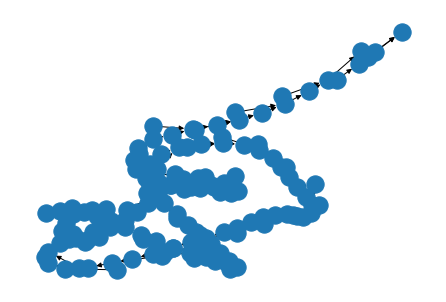

In [4]:
graph, genomes = eu.generate_nx_from_msa(test_ids[:10], aa_level=True)
collapsed = eu.collapse_graph(graph)


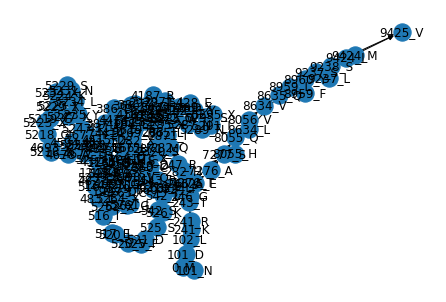

In [16]:
nx.draw(collapsed, with_labels=True)

In [17]:
def msa_from_screed_ids(ids): 
    for seq_id in ids:
        record = msadb[seq_id]
        name = ">"+record["name"]
        sequence = str(record["sequence"])
        yield name
        yield sequence


In [18]:
for i in msa_from_screed_ids(test_ids[:10]):
    print(i)

>EPI_ISL_542487
----------
>EPI_ISL_542488
----------
>EPI_ISL_542489
----------
>EPI_ISL_542490
----------
>EPI_ISL_542491
----------
>EPI_ISL_542492
----------
>EPI_ISL_542493
----------
>EPI_ISL_542494
----------
>EPI_ISL_542495
----------
>EPI_ISL_542496
----------


In [24]:
records_aas = []
for ix, record in enumerate(test_records):
    records_aas.append(f">{record['name']}")
    records_aas.append(translate_record(record))


In [32]:
AA_alphabet = 


In [33]:
houston_10000_aas = "\n".join(records_aas)
graph, genomes = es.generate_nx_from_msa(houston_10000_aas, accepted_letters=AA_alphabet)

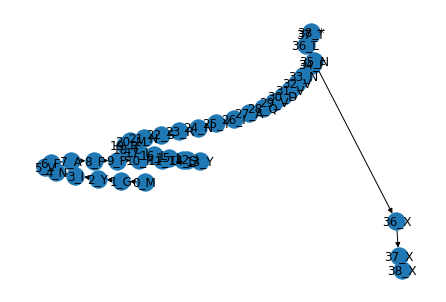

In [34]:
nx.draw(graph, with_labels=True)

In [194]:
grouped_aas = list(zip(*records_aas))
grouped_aas[0][:100]

('MGYINVFAFPFTIYSLLLCRMNSRNYIAQVDVVNFNLT*',
 'MGYINVFAFPFTIYSLLLCRMNSRNYIAQVDVVNFNLT*',
 'MGYINVFAFPFTIYSLLLCRMNSRNYIAQVDVVNFNLT*',
 'MGYINVFAFPFTIYSLLLCRMNSRNYIAQVDVVNFNLT*',
 'MGYINVFAFPFTIYSLLLCRMNSRNYIAQVDVVNFNLT*',
 'MGYINVFAFPFTIYSLLLCRMNSRNYIAQVDVVNFNLT*',
 'MGYINVFAFPFTIYSLLLCRMNSRNYIAQVDVVNFNLT*',
 'MGYINVFAFPFTIYSLLLCRMNSRNYIAQVDVVNFNLT*',
 'MGYINVFAFPFTIYSLLLCRMNSRNYIAQVDVVNFNLT*',
 'MGYINVFAFPFTIYSLLLCRMNSRNYIAQVDVVNFNLT*',
 'MGYINVFAFPFTIYSLLLCRMNSRNYIAQVDVVNFNLT*',
 'MGYINVFAFPFTIYSLLLCRMNSRNYIAQVDVVNFNLT*',
 'MGYINVFAFPFTIYSLLLCRMNSRNYIAQVDVVNFNLT*',
 'MGYINVFAFPFTIYSLLLCRMNSRNYIAQVDVVNFNLT*',
 'MGYINVFAFPFTIYSLLLCRMNSRNYIAQVDVVNFNLT*',
 'MGYINVFAFPFTIYSLLLCRMNSRNYIAQVDVVNFNLT*',
 'MGYINVFAFPFTIYSLLLCRMNSRNYIAQVDVVNFNLT*',
 'MGYINVFAFPFTIYSLLLCRMNSRNYIAQVDVVNFNLT*',
 'MGYINVFAFPFTIYSLLLCRMNSRNYIAQVDVVNFNLT*',
 'MGYINVFAFPFTIYSLLLCRMNSRNYIAQVDVVNFNLT*',
 'MGYINVFAFPFTIYSLLLCRMNSRNYIAQVDVVNFNLT*',
 'MGYINVFAFPFTIYSLLLCRMNSRNYIAQVDVVNFNLT*',
 'MGYINVFAFPFTIYSLLLCRMNSRNYIAQV

In [ ]:
records_aas

In [129]:
t = "AT-G--FAFAFASD------asdADADSad"
get_dash = re.compile("-+")
min([len(i)%3 == 0 for i in get_dash.findall(t)])

False

In [132]:
get_dash.split(t)

['AT', 'G', 'FAFAFASD', 'asdADADSad']

In [123]:
test = match_line_to_reference(str(test_records[3]["sequence"]))


Seq('TFDLL*ICSLNEL*NLCGCHSAACLVHSRSIINN*LLSLTGHE*LVYLLQAAYG...KKK', HasStopCodon(ExtendedIUPACProtein(), '*'))

In [6]:
sum_real_chars = 0
sum_interval_lens = 0
with open("../data/msa_0408/reference_msa.txt") as src:
    intervals = []
    line = src.readlines()[0]
    interval_len = 0
    interval_pos = -1
    for ix, char in enumerate(line):
        ix += 1
        if char == "-":
            if interval_pos != -1:
                sum_interval_lens += interval_len
                intervals.append((interval_pos, interval_len))
                interval_len = 0
                interval_pos = -1
                
        else:
            sum_real_chars += 1
            if interval_pos == -1:
                interval_pos = ix
            interval_len += 1
    
    if interval_pos != -1:
        sum_interval_lens += interval_len
        intervals.append((interval_pos, interval_len))
            
#     print(intervals)

In [ ]:
"awk '/^>/{print $1} !/^>/{print " + " ".join([f"substr($0, {i[0]}, {i[1]})" for i in intervals]) + "}'"

In [3]:
metadata = pd.read_csv("../data/metadata_2021_04_08.tsv", sep="\t", parse_dates = ["Collection date", "Submission date"])

/apps/software/standard/compiler/gcc/9.2.0/jupyter_conda/2019.10-py3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (13,16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
metadata.columns

Index(['Virus name', 'Type', 'Accession ID', 'Collection date', 'Location',
       'Additional location information', 'Sequence length', 'Host',
       'Patient age', 'Gender', 'Clade', 'Pango lineage', 'Pangolin version',
       'Variant', 'AA Substitutions', 'Submission date', 'Is reference?',
       'Is complete?', 'Is high coverage?', 'Is low coverage?', 'N-Content',
       'GC-Content'],
      dtype='object')

In [14]:
metadata["aa_sub_len"] = metadata["AA Substitutions"].apply(lambda row: len(str(row).split(",")))

In [16]:
metadata["aa_sub_len"].mean()

14.777207618015215

In [114]:
aadata = metadata[["Accession ID", \
                   "Collection date", \
                   "Submission date", \
                   "Location", \
                   "Additional location information", \
                   "Sequence length", \
                   "Host", \
                   "AA Substitutions", \
                   "Is reference?"]]
def get_nth_slash(row, n):
    try:
        return row.split("/")[n].strip()
    except:
        return np.nan
    
for i in range(4):
    aadata[f"Location_{i}"] = aadata["Location"].apply(lambda row: get_nth_slash(row, i))

/apps/software/standard/compiler/gcc/9.2.0/jupyter_conda/2019.10-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [142]:
mutant_list = dict()
for mutants, count in aadata[aadata.Location_3 == "Houston"]["AA Substitutions"].value_counts().reset_index().to_numpy():
    mutants = mutants.replace("(", "").replace(")", "").split(",")
    for mutant in mutants:
        if mutant.strip() == "" or "ins" in mutant:
            continue
        protein, mutation = mutant.split("_")
        position = mutation.replace("el", "").replace("top", "")[1:-1]
        mutant_list.setdefault(protein, []).append(int(position))
#     break

In [143]:
mutant_list.keys()

dict_keys(['N', 'NS3', 'NSP2', 'NSP12', 'NSP5', 'Spike', 'NSP16', 'NS8', 'NSP14', 'NSP3', 'NSP6', 'NSP13', 'NSP1', 'E', 'NS6', 'NSP4', 'NS7a', 'NSP15', 'NSP8', 'NSP9', 'M', 'NSP7', 'NSP10', 'NS7b', 'NSP11'])